## 01. PyTorch Workflow

**An example PyTorch end-to-end workflow.**
1. get data (prepare and load) (turn into tensors)
2. build or pick a pretrained model
3. fit the model to data (training)
4. make predictions and evaluate the model (inference)
5. saving and loading a model
6. put all together

In [1]:
import torch
# nn -> contains all of pytorch's building blocks for neural networks
# https://pytorch.org/docs/stable/nn.html
from torch import nn
import matplotlib.pyplot as plt

### 1. Data Preparation

excel speadsheet / images / videos / audio / text ...

-> get data into a numberical representation.

-> build a model to learn patterns in that numberical representation.

Use a linear regression formula to make a straight line with known *parameters*.

In [2]:
# parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

print(X[:10])
print(y[:10])
print(len(X), len(y))

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])
tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])
50 50


**Splitting data into training and testng sets**

In [3]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [4]:
# visualize
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
    """
    Plots training data, test data and compares predictions
    """
    plt.figure(figsize=(8, 6))

    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})
    plt.grid()

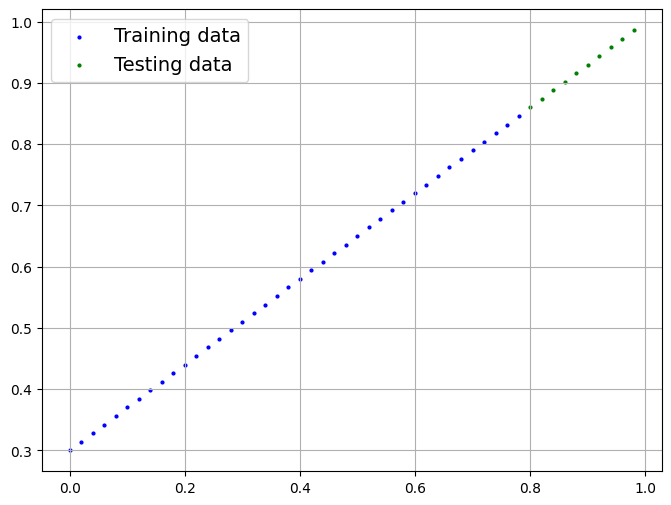

In [5]:
plot_predictions()

### 2. Build PyTorch model

**2 main algorithms:**
- Gradient descent
- backpropagation

In [6]:
# create a linear regression model class
class LinearRegressionModel(nn.Module):
    # almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        # a kind of Tensor that is to be considered a module parameter
        self.weights = nn.Parameter(torch.rand(1,
                                               requires_grad=True,  # gd -> True
                                               dtype=torch.float))
        self.bias = nn.Parameter(torch.rand(1,
                                            requires_grad=True,
                                            dtype=torch.float))
        # requires_grad: will track the gradients of this specific parameter for
        # use with torch. autograd and gradient descent (for many torch.nn
        # modules, requires_grad=True is set by default)

    # any subclass of n. Module needs to override forward ()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ to define the computation in the model """
        # x: input data
        return self.weights * x + self.bias


**Model building essentials**

- torch.nn
- torch.nn.Parameter -> what parameters should model try and learn -> pytorch layer from torch.nn will set these for us
- torch.nn.Module -> the base class for all neural network modules -> subcless must overwrite `forward()`
- torch.optim -> where the optimizers in pytorch live -> help with gradient descent
- def forward() -> define what happens in the forward computation
- torch.utils.data.Dataset -> represents a map between key(label) and sample(features) pairs of data -> images and associated labels
- torch.utils.data.DataLoader -> creates a python iterable over a torch dataset (to iterate over datas

---
- torchvision.transforms -> torchvision: pytorch's computer vision
- torchvision.models

---
- torchmetrics -> to evaluate the model
- torch.utils.tensorboard -> to improve through experimentation

**Check the contents of PyTorch model**

check the model parameters using `.parameters()`

In [7]:
# create a random seed
torch.manual_seed(42)

# create an instance of the model
model_0 = LinearRegressionModel()

# check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [8]:
# list named parameters -> get a dictionary of parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

**Make presictions using `torch.inference_mode()`**

In [9]:
y_preds = model_0(X_test)
y_preds

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]], grad_fn=<AddBackward0>)

difference:

inference -> turn off the gradient tracking -> do not training

In [10]:
with torch.inference_mode():
    y_preds = model_0(X_test)

# similar, but inference_mode is preferred (faster way?)
# with torch.no_grad():
#     y_preds = model_0(X_test)

y_preds

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])

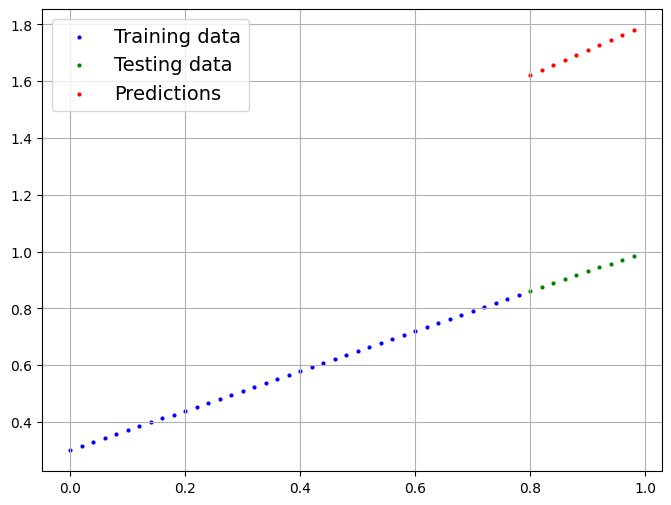

In [11]:
plot_predictions(predictions=y_preds)

### 3. Train Model

- **loss function:** https://pytorch.org/docs/stable/nn.html#loss-functions
    - may also be called *cost function* or *criterion*
    - e.g. nn.L1Loss (MAE) / nn.MSELoss (squared L2 norm) / nn.CrossEntropyLoss


- **optimizer:** https://pytorch.org/docs/stable/optim.html?highlight=optimizer#module-torch.optim
    - takes into account the loss of a model and adjusts the model parameters accordingly

In [12]:
# set up a loss function
loss_func = nn.L1Loss()

# set up a optimizer
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)      # learning rate

In [13]:
print('parameters before training:')
model_0.state_dict()

parameters before training:


OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

**Build a training loop (and a testing loop) in PyTorch**

(1) loop through the data

(2) forward pass (forwars propagation) (data moving through the model's `forward()`) to make prediction on data

(3) calculate the loss

(4) optimizer zero grad

(5) loss backward -> move backwards through the network to calculate the gradients of each of the parameters of the model with respect to the loss (*backward propagation*)

(6) optimizer step -> use the optimizer to adjust model's parameters to try and improve the loss (*gradient descent*)

In [14]:
%%time

# epoch -> one loop through the data -> hyperparameters
epochs = 100

epoch_count = []
train_loss = []
test_loss = []

for epoch in range(epochs):
    # set the model to training mode
    # train mode in pytorch sets all parameters that require gradients to require gradients?
    model_0.train()

    # (2) forward pass on training data
    y_pred = model_0(X_train)

    # (3) calculate the loss value
    loss = loss_func(y_pred, y_train)

    # (4) optimizer zero grad -> zero the optimizer gradients
    optimizer.zero_grad()

    # (5) backpropagation
    # (compute the gradient of every parameter with requires grad=True)
    loss.backward()

    # (6) perform GD -> to update the model's parameters with respect to the
    # gradients calculated by `loss.backward()`
    # by default -> how the optimizer changes will accumulate through the loop
    # -> so: zero them above in step (4) for the next iteration of the loop
    optimizer.step()

    """ testing code """
    # turns off the gradients tracking
    model_0.eval()

    # in testing -> do not need the gradients tracking
    with torch.inference_mode():
        # 1. do forward pass
        test_pred = model_0(X_test)

        # calculate the loss
        t_loss = loss_func(test_pred, y_test)


    if (epoch % 10 == 0):
        epoch_count.append(epoch)
        train_loss.append(loss)
        test_loss.append(t_loss)
        print(f"Epoch: {epoch} | MAE train Loss: {loss} | test loss: {t_loss}")
        print(model_0.state_dict())


Epoch: 0 | MAE train Loss: 0.6860889196395874 | test loss: 0.7637526988983154
OrderedDict([('weights', tensor([0.8784])), ('bias', tensor([0.9050]))])
Epoch: 10 | MAE train Loss: 0.5708791017532349 | test loss: 0.6290428042411804
OrderedDict([('weights', tensor([0.8394])), ('bias', tensor([0.8050]))])
Epoch: 20 | MAE train Loss: 0.45566922426223755 | test loss: 0.4943329691886902
OrderedDict([('weights', tensor([0.8004])), ('bias', tensor([0.7050]))])
Epoch: 30 | MAE train Loss: 0.340459406375885 | test loss: 0.35962313413619995
OrderedDict([('weights', tensor([0.7614])), ('bias', tensor([0.6050]))])
Epoch: 40 | MAE train Loss: 0.22524945437908173 | test loss: 0.2249133139848709
OrderedDict([('weights', tensor([0.7224])), ('bias', tensor([0.5050]))])
Epoch: 50 | MAE train Loss: 0.1100396141409874 | test loss: 0.09020347893238068
OrderedDict([('weights', tensor([0.6834])), ('bias', tensor([0.4050]))])
Epoch: 60 | MAE train Loss: 0.009724984876811504 | test loss: 0.020998019725084305
Ord

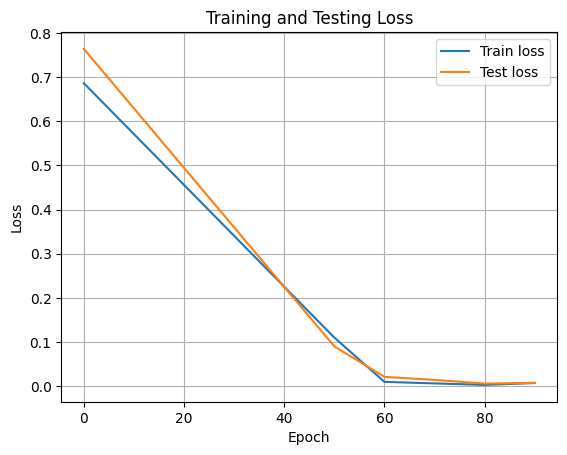

In [15]:
# plot the loss curves
import numpy as np

# convert tensor to numpy array
train = np.array(torch.tensor(train_loss).numpy())
test = np.array(torch.tensor(test_loss).numpy())

plt.plot(epoch_count, train, label='Train loss')
plt.plot(epoch_count, test, label='Test loss')

plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid()

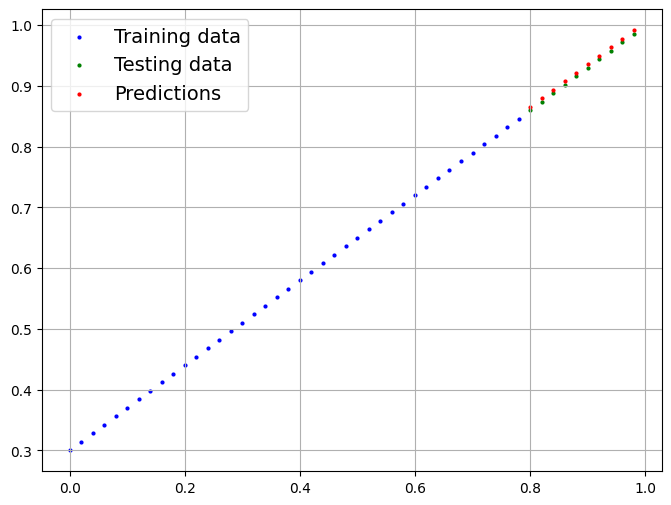

In [16]:
# make predictions
with torch.inference_mode():
    y_pred_new = model_0(X_test)

plot_predictions(predictions=y_pred_new)

### 4. Save and load a model

https://pytorch.org/tutorials/beginner/saving_loading_models.html

**3 main methods:**

(1) `torch.save()`
- saves a serialized object to disk
- uses Python's pickle format
- python pickle: pickle module -> implements binary protocols for serializing and de-serializing a Python object structure

(2) `torch.load()`
- uses pickle's unpickling facilities to deserialize pickled object files to memory

(3) `torch.nn.Module.load_state_dict()`
- load a model's saved state (parameter) dictionary

---
Also:
- sava/load `state_dict` (recommended)
    - save:
        - torch.save(model.state_dict(), PATH)
    - load: 
        - model = TheModelClass(*args, **kwargs)
        - model.load_state_dict(torch.load(PATH))
        - model.eval()

- sava/load `entire model`
    - save:
        - torch.save(model, PATH)
    - load:     # Model class must be defined somewhere
        - model = torch.load(PATH)
        - model.eval()

In [17]:
# save model
from pathlib import Path

# 1. create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. create mode save path
# common PyTorch convention to save models: .pt or .pth file extension
MODEL_NAME = "01_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(MODEL_SAVE_PATH)

# 3. save the model state dict
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

models/01_workflow_model_0.pth


In [18]:
# check files
!ls -l models

total 16
-rw-r--r--  1 wzy  staff  1568 Jul 13 20:39 01_workflow_model_0.pth
-rw-r--r--  1 wzy  staff  1632 Jul 13 20:35 01_workflow_model_1.pth


In [19]:
# load model

# creata a new instance of the model class
load_model_0 = LinearRegressionModel()

# load the state dict
load_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

print(load_model_0.state_dict())

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])


In [20]:
# make some predictions with load_model_0
load_model_0.eval()
with torch.inference_mode():
    load_pred = load_model_0(X_test)

load_pred

tensor([[0.8661],
        [0.8801],
        [0.8940],
        [0.9080],
        [0.9220],
        [0.9359],
        [0.9499],
        [0.9638],
        [0.9778],
        [0.9917]])

In [21]:
# compare loaded model predictions with the originals model predictions
y_pred_new == load_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### 5. Put all together

**set up device agnostic code**

In [22]:
device = "mps" if getattr(torch, 'has_mps', False) \
    else "gpu" if torch.cuda.is_available() else "cpu"
device

/var/folders/df/mx2gggdn7p55_8g8_fxxk8zc0000gn/T/ipykernel_83291/1217012076.py:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = "mps" if getattr(torch, 'has_mps', False) \


'mps'

#### 5.1 Data

In [23]:
# parameters
weight = 0.7
bias = 0.5

# create range values
start = 0
end = 1
step = 0.02
# create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [24]:
# split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

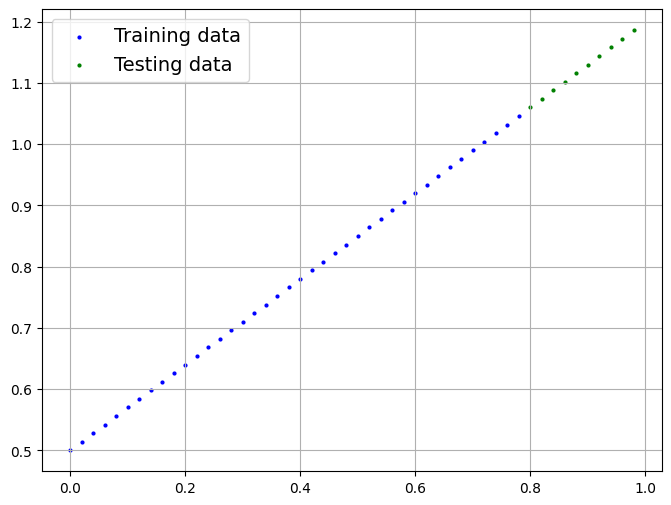

In [25]:
plot_predictions(X_train, y_train, X_test, y_test)

#### 5.2 Build pytorch linear model

In [26]:
# create a linear model by subclassing nn.Modile
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # use nn.Linear() to build a linear layer -> create the model parameters
        # also called: linear transform, probing leyer, fully connected layer, dense layer
        self.linear_layer = nn.Linear(in_features=1,    # an input of size 1
                                      out_features=1)   # an output of size 1


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ to define the computation in the model """
        return self.linear_layer(x)

In [27]:
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [28]:
# check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [29]:
# set the model to target device
model_1.to(device)
next(model_1.parameters()).device

device(type='mps', index=0)

#### 5.3 Training

In [30]:
loss_func = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [31]:
%%time
torch.manual_seed(42)

# put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

epochs = 100
epoch_count = []
train_loss = []
test_loss = []

for epoch in range(epochs):
    model_1.train()

    # forward pass
    y_pred = model_1(X_train)
    # calculate the loss
    loss = loss_func(y_pred, y_train)
    # zero the optimizer
    optimizer.zero_grad()
    # backpropagattion
    loss.backward()
    # GD
    optimizer.step()

    # testing code
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        t_loss = loss_func(test_pred, y_test)

    if (epoch % 10 == 0):
        epoch_count.append(epoch)
        train_loss.append(loss)
        test_loss.append(t_loss)
        print(f"Epoch: {epoch} | MAE train Loss: {loss} | test loss: {t_loss}")
        print(model_1.state_dict())


/Users/wzy/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/autograd/__init__.py:204: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/Users/wzy/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/_tensor_str.py:137: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:248.)
  nonzero_finite_vals = torch.masked_select(


Epoch: 0 | MAE train Loss: 0.35517793893814087 | test loss: 0.37397629022598267
OrderedDict([('linear_layer.weight', tensor([[0.7606]], device='mps:0')), ('linear_layer.bias', tensor([0.8200], device='mps:0'))])
Epoch: 10 | MAE train Loss: 0.23996806144714355 | test loss: 0.23926639556884766
OrderedDict([('linear_layer.weight', tensor([[0.7216]], device='mps:0')), ('linear_layer.bias', tensor([0.7200], device='mps:0'))])
Epoch: 20 | MAE train Loss: 0.12475819885730743 | test loss: 0.10455658286809921
OrderedDict([('linear_layer.weight', tensor([[0.6826]], device='mps:0')), ('linear_layer.bias', tensor([0.6200], device='mps:0'))])
Epoch: 30 | MAE train Loss: 0.012664328329265118 | test loss: 0.021324647590517998
OrderedDict([('linear_layer.weight', tensor([[0.6474]], device='mps:0')), ('linear_layer.bias', tensor([0.5255], device='mps:0'))])
Epoch: 40 | MAE train Loss: 0.0077468291856348515 | test loss: 0.017235923558473587
OrderedDict([('linear_layer.weight', tensor([[0.6632]], device=

In [32]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6948]], device='mps:0')),
             ('linear_layer.bias', tensor([0.4995], device='mps:0'))])

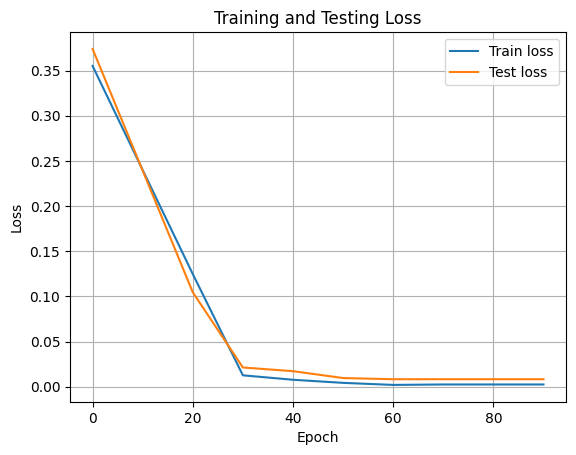

In [33]:
# plot the loss curves
import numpy as np

# convert tensor to numpy array
train = np.array(torch.tensor(train_loss).cpu().numpy())
test = np.array(torch.tensor(test_loss).cpu().numpy())

plt.plot(epoch_count, train, label='Train loss')
plt.plot(epoch_count, test, label='Test loss')

plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.grid()

#### 5.4 Make and evaluate predictions

In [34]:
model_1.eval()

with torch.inference_mode():
    y_pred = model_1(X_test)

y_pred

tensor([[1.0553],
        [1.0692],
        [1.0831],
        [1.0970],
        [1.1109],
        [1.1248],
        [1.1387],
        [1.1526],
        [1.1665],
        [1.1804]], device='mps:0')

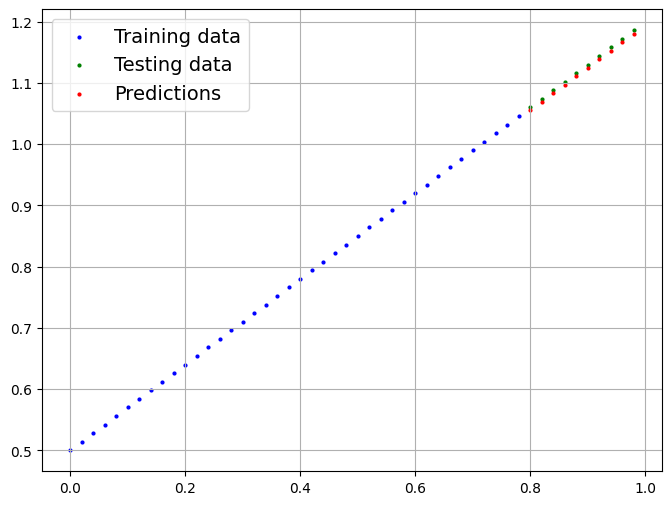

In [35]:
plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), predictions=y_pred.cpu())

#### 5.5 Save and load model

In [36]:
# save model
from pathlib import Path

# create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. create model save path
MODEL_NAME = "01_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(MODEL_SAVE_PATH)

# save the model_1
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

models/01_workflow_model_1.pth


In [40]:
# load model
load_model_1 = LinearRegressionModelV2()

# load the state dict
load_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


load_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [41]:
next(load_model_1.parameters()).device

device(type='mps', index=0)

In [42]:
# make some predictions with load_model_1
load_model_1.eval()
with torch.inference_mode():
    load_pred = load_model_1(X_test)

load_pred == y_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')